<a href="https://colab.research.google.com/github/Aldarion96/Projects/blob/main/Alza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
import pandas as pd
import matplotlib.pyplot as plt

df_retail = pd.read_excel (r'/content/sample_data/Online Retail.xlsx')
print (df_retail)

       InvoiceNo StockCode  ... CustomerID         Country
0         536365    85123A  ...    17850.0  United Kingdom
1         536365     71053  ...    17850.0  United Kingdom
2         536365    84406B  ...    17850.0  United Kingdom
3         536365    84029G  ...    17850.0  United Kingdom
4         536365    84029E  ...    17850.0  United Kingdom
...          ...       ...  ...        ...             ...
541904    581587     22613  ...    12680.0          France
541905    581587     22899  ...    12680.0          France
541906    581587     23254  ...    12680.0          France
541907    581587     23255  ...    12680.0          France
541908    581587     22138  ...    12680.0          France

[541909 rows x 8 columns]


**Úprava datasetu:**

*čištění*
-řádky s Description pouze znaky, wrong, wrongly, 
- řádky kde není C ale je quantity záporný
- prázdné pole Description s nulovou cenou
- A = Adjust bad debt
- C = zrušené nákupy (10 000 řádků)

*Vytvořit*
- sloupec flag
-sloupec profit (quantity * price)



*Vizualizace*
- ze které země se nakupuje nejvíce
- jaký produkt se nakupuje nejvíce
celkový profit/ztráta / za kvartál
 

**Identifikování chybějících dat**

In [106]:
df_retail.info()
df_retail.dtypes
df_retail.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


(541909, 8)

In [107]:
df_retail.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [108]:
for column in df_retail.columns:
    percentage = df_retail[column].isnull().mean()
    print(f'{column}: {round(percentage*100, 2)}%')

InvoiceNo: 0.0%
StockCode: 0.0%
Description: 0.27%
Quantity: 0.0%
InvoiceDate: 0.0%
UnitPrice: 0.0%
CustomerID: 24.93%
Country: 0.0%


**Čištění**

*Duplicitiní hodnoty*

In [109]:
shape_a = df_retail.drop_duplicates()
shape_a = shape_a.shape
shape_b = df_retail.shape

duplicates=shape_b[0]-shape_a[0]
print(shape_a)
print(shape_b )
print(duplicates)

(536641, 8)
(541909, 8)
5268


*Odstranení v sloupci Description*

In [157]:
clear_df = df_retail[~df_retail.Description.str.contains("\?|wrong|damage|crushed|missing|destroyed|lost|mouldy|wet|thrown|smashed|check|Dotcom|Printing|broken|counted|problem|away|ebay|incorrect", na=False,case=False)]
clear_df = clear_df.drop_duplicates()

In [111]:
#clear_df.query("Description == 'wrong code'")

**1. Jaký produkt se prodává nejvíce:**

počet nákupů

In [154]:
sells_df = clear_df.assign(sells = 1)
sells_df[['Description','StockCode','sells']].groupby(['StockCode','Description']).count().sort_values('sells',ascending = False)

,,sells
StockCode,Description,
85123A,WHITE HANGING HEART T-LIGHT HOLDER,2302
22423,REGENCY CAKESTAND 3 TIER,2200
85099B,JUMBO BAG RED RETROSPOT,2159
47566,PARTY BUNTING,1727
20725,LUNCH BAG RED RETROSPOT,1638
...,...,...
84968f,SET OF 16 VINTAGE SKY BLUE CUTLERY,1
35650,VINTAGE BEAD PINK JEWEL STAND,1
35832,WOOLLY HAT SOCK GLOVE ADVENT STRING,1


**počet prodaných kusů**

In [155]:
sells_df[['Description','StockCode','Quantity']].groupby(['StockCode','Description']).sum().sort_values('Quantity',ascending = False).head()

,,Quantity
StockCode,Description,
84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,53847
85099B,JUMBO BAG RED RETROSPOT,47363
84879,ASSORTED COLOUR BIRD ORNAMENT,36381
22197,POPCORN HOLDER,36334
21212,PACK OF 72 RETROSPOT CAKE CASES,36039


**Ve které zemi se prodává nejvíce:**

**Vytvoření pmocných sloupců.**


- **total** = celkový výnos/ztráta
- **flag** = počet zakoupení
- **quantity** = čeho se prodalo nejvíce / nejméně




In [156]:
df_countries = df_retail[['Country']].assign(sells = 1).groupby('Country').count().sort_values('sells',ascending = False)
df_countries['percent'] = round((df_countries['sells']  / df_countries['sells'].sum()*100),2)
df_countries.head()



,sells,percent
Country,,
United Kingdom,495478,91.43
Germany,9495,1.75
France,8557,1.58
EIRE,8196,1.51
Spain,2533,0.47


**Zisk / Ztráta**

Tabulka s vypočítanou ziskovostí či ztrátovostí

In [115]:
df_profit = df_retail.assign(total = (df_retail.Quantity * df_retail.UnitPrice))
df_profit.head(3)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00


In [116]:
df_profit = df_profit[['Description','StockCode','total']].groupby(['StockCode','Description']).sum().sort_values('total',ascending = False)

In [117]:
df_profit_Stock = df_profit.query("total != 0").sort_values('total', ascending = False)
df_profit_Stock = df_profit_Stock.query("total > 0") 
df_profit_Stock

,,total
StockCode,Description,
DOT,DOTCOM POSTAGE,206245.480
22423,REGENCY CAKESTAND 3 TIER,164762.190
47566,PARTY BUNTING,98302.980
85123A,WHITE HANGING HEART T-LIGHT HOLDER,97715.990
85099B,JUMBO BAG RED RETROSPOT,92356.030
...,...,...
51014c,"FEATHER PEN,COAL BLACK",0.830
85047,WHITE BEADED GARLAND STRING 20LIGHT,0.800
23366,SET 12 COLOURING PENCILS DOILEY,0.650


In [118]:
#df_profit_charges = df_profit.query("total < 0") 
#df_profit_charges = df_profit_charges.reset_index()
#df_profit_charges = df_profit_charges.StockCode.str.isnumeric()
#df_profit_charges

**Ziskovost celkově za dny/měsíce/kvartály**

In [119]:
df_days = df_retail.assign(total = (df_retail.Quantity * df_retail.UnitPrice))

In [120]:
df_days.index = pd.to_datetime(df_days['InvoiceDate'],format='%m/%d/%y %I:%M%p')

In [184]:
df_days = df_days[['total']].groupby(pd.Grouper(freq='d')).sum().sort_values('InvoiceDate')
df_days

,total
InvoiceDate,
2010-12-01,58635.56
2010-12-02,46207.28
2010-12-03,45620.46
2010-12-04,0.00
2010-12-05,31383.95
...,...
2011-12-05,57751.32
2011-12-06,54228.37
2011-12-07,75076.22


In [196]:
df_months = df_days.query("InvoiceDate >= '2011-01-01'")
df_months = df_months[['total']].groupby(pd.Grouper(freq='m')).sum().sort_values('InvoiceDate')
df_months

,total
InvoiceDate,
2011-01-31,560000.260
2011-02-28,498062.650
2011-03-31,683267.080
2011-04-30,493207.121
2011-05-31,723333.510
2011-06-30,691123.120
2011-07-31,681300.111
2011-08-31,682680.510
2011-09-30,1019687.622


**GRAF**

In [210]:
months_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

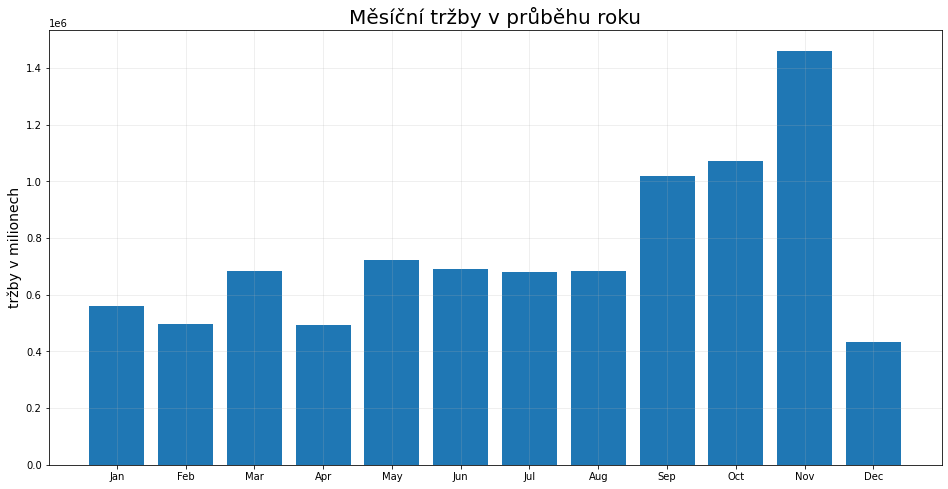

In [217]:
fig, ax = plt.subplots(figsize=(16,8))
plt.bar(months_list, df_months['total'])
ax.set_title('Měsíční tržby v průběhu roku',fontsize=20)
ax.set_ylabel('tržby v milionech',fontsize=14)
ax.grid(alpha=0.25)

osekat na jeden rok

In [123]:
df_quartal = df_days.query("InvoiceDate >= '2011-01-01'")

In [124]:
df_quartal[['total']].groupby(pd.Grouper(freq='q')).sum().sort_values('InvoiceDate')

,total
InvoiceDate,
2011-03-31,1741329.990
2011-06-30,1907663.751
2011-09-30,2383668.243
2011-12-31,2966128.930
